### **Objective**

In this notebook we will solve the same problem of recognizing Handwritten digits using Logistic regression model.

### **Imports**


In [50]:
# Common imports 
import numpy as np
from pprint import pprint  

# to make this notebook's output stable across runs
np.random.seed(42) 

# sklearn specific imports 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.pipeline import make_pipeline 
from sklearn.dummy import DummyClassifier 
from sklearn.linear_model  import SGDClassifier, RidgeClassifier, LogisticRegression 
from sklearn.model_selection import cross_validate, RandomizedSearchCV, cross_val_predict 

# log loss is also known as cross entropy loss
from sklearn.metrics import log_loss 
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.metrics import precision_score, recall_score, classification_report 
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_curve, roc_auc_score 

#scipy 
from scipy.stats import loguniform 

# To plot pretty figures 
%matplotlib inline 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns;sns.set()

# global settings 
mpl.rc('axes',labelsize=14) 
mpl.rc('xtick',labelsize=12) 
mpl.rc('ytick',labelsize=12) 
mpl.rc('figure',figsize=(8,6))


In [51]:
# Ignore all warnings (convergence..) by sklearn
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

## **Handwritten Digit Classification** 

* We are going to use **LogisticRegression** (despite it's name) to classify a given digit image. Again, we first apply the model for binary classification and then extend it to multiclass classification.

* Suppose we want to recognize whether the given image is of digit zero or not (digits other than zero). Then the problem could be case as binary classification problem.

* The first step is to create a dataset that contains collection of digit images (also called examples, samples) written by humans. Then each image should be labelled properly.

* Fortunately, we have a standard benchmark dataset called **MNIST**.

In [52]:
from sklearn.datasets import fetch_openml

# it returns the data and labels as a panda dataframe.
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

The data matrix $X$ and the respective label vector $y$ need to be converted to numpy array by calling a `to_numpy` method.

In [53]:
X = X.to_numpy()
y = y.to_numpy()

#### **Preprocessing** 

* Unlike perceptron, where scaling the range is optional(but recommended), sigmoid requires range between 0 to 1.

* Contemplate the consequence if we don't apply the scaling operation on the input datapoints.

* **NOTE** : **Do not** apply mean centering as it removes zeros from the data, however zeros should be zeros in the dataset.

* Since we are using only one preprocessing step, using `pipeline` may not be required.

In [54]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [55]:
print('Mean of the features : ', np.mean(X))
print('Standard Deviation : ', np.std(X))
print('Minimum value : ', np.min(X))
print('Maximum value : ', np.max(X))

Mean of the features :  0.13092720382627604
Standard Deviation :  0.3084510570135976
Minimum value :  0.0
Maximum value :  1.0


Let's get some information about the dataset. 


In [56]:
print('Number of targets : {0} ,type : {1}'.format(X.shape[0] ,X.dtype))
print('Number of features : {0}'.format(X.shape[1]))
print()
print('Number of classes : {0} ,type : {1}'.format(len(np.unique(y)) ,y.dtype))
print('Labels : {0}'.format(np.unique(y)))

Number of targets : 70000 ,type : float64
Number of features : 784

Number of classes : 10 ,type : object
Labels : ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']



Note that the labels are of string data type.

#### **Data visualization**

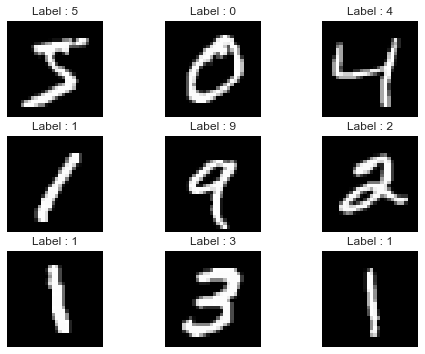

In [57]:
num_images = 9 
factor = int(np.sqrt(num_images)) 
fig,ax = plt.subplots(nrows=factor, ncols = factor, figsize=(8,6))
idx_offset  = 0 

for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
        ax[i,j].set_title('Label : {0}'.format(str(y[index+j])))
        ax[i,j].set_axis_off()

#### **Data splitting**

In [58]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Before proceeding further, we need to check whether the datasset is balanced or imbalanced. 

We can do it by plotting the distribution of samples in each classes. 

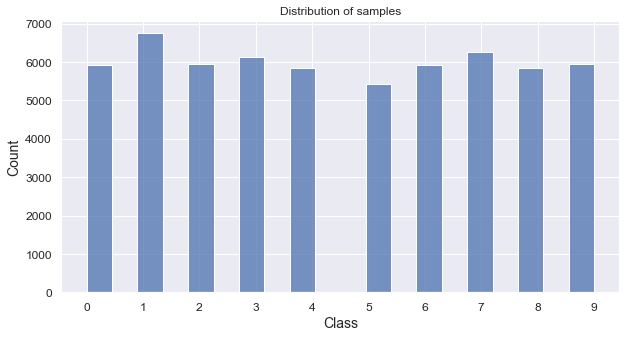

In [59]:
plt.figure(figsize=(10,5))
sns.histplot(data=np.int8(y_train) ,binwidth=0.45 ,bins=11)

plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9] ,label=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

## **Binary Classification : 0 - Detector** 

* Let us start with a simple classification problem, that is, binary classification.

* Since the original label vector contains 10 classes, we need to modify the number of classes to 2. Therefore, the label '0' will be changed to '1' and all other labels(1-9) will be changed to '0' 

* **NOTE: For perceptron we set the negative labels to -1**

In [60]:
# initialize new variables names with all 0.
y_train_0 = np.zeros((len(y_train)))
y_test_0 = np.zeros((len(y_test)))

# find indices of digit 0 image
# remember original labels are of type str not int
indx_0 = np.where(y_train=='0') 

# use those indices to modify y_train_0 & y_test_0 
y_train_0[indx_0] = 1 
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

#### **Visualization of new variables**

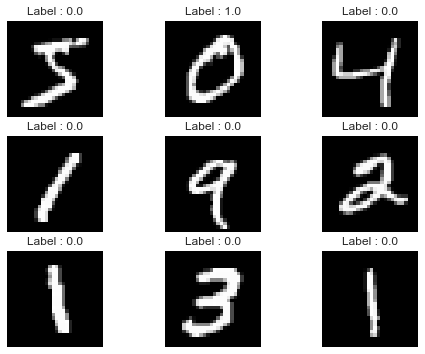

In [61]:
num_images = 9  
factor = np.int(np.sqrt(num_images))

fig, ax = plt.subplots(nrows=factor, ncols=factor,figsize=(8,6))
idx_offset = 0 

for i in range(factor):
    index = idx_offset+ i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
        ax[i,j].set_title('Label : {0}'.format(str(y_train_0[index+j])))
        ax[i,j].set_axis_off()

## **Model**

### **Baseline Models**

Let us quickly construct a baseline model with the following rule :

1. Count number of samples per class.

2. The model **always output** the class which has highest number of samples.

3. Then calculate the accuracy of the baseline model.

In [62]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == 0)[0])

print(num_pos)
print(num_neg)


5923
54077


In [63]:
base_clf = DummyClassifier(strategy='most_frequent') 
base_clf.fit(X_train,y_train_0)

print(base_clf.score(X_train,y_train_0))

0.9012833333333333


Now the reason is obvious. The model would have predicted 54077 samples correctly just by outputing 0 for all the input samples. 

Therefore the accuracy will be $\frac{54077}{60000} = 90.12 \%$

### **Logistic Regression model** 

Quick recap of various components in the general settings:


1. **Training data** : 

    * consists of features & labels or $(\mathbf X,y)$ 

    * Here, $y$ is a **discrete** number from a finite set.

    * **Features** in this case are **pixel** values of an image.
2. **Model** : 
$$ z = w_0x_0 + w_1x_1+ \ldots + w_mx_m$$

$$ = \mathbf w^{T} \mathbf x$$ 

and passing it through the sigmoid non-linear function (or Logistic function)

$$ \sigma(z)=\frac{1}{1+e^{-z}}$$

3. **Loss function**: 

\begin{equation} 
J(\mathbf w) = -\frac{1}{n} \mathbf \sum [y^{(i)} \log(h_w(\mathbf x^{(i)}))+(1-y^{(i)})(1-\log(h_w(\mathbf x^{(i)})))] 
\end{equation}

4. **Optimization**: 


Let's quickly take a look into the important parameters of the SGDClassifier() estimator:

**class sklearn.linear_model.SGDClassifier** **`(loss='hinge', * ,penalty='l2', alpha=0.0001, l1_ratio = 0.15, fit_intercept =True, max_iter =1000, tol=0.001, shuffle=True, verbose =0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate = 'optimal', eta0=0.0, power_t = 0.5, early_stopping = False, validation_fraction =0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)`**.


* **IMPORTANT** : 
**Setting the loss parameter to `loss=log` makes it a logistic regression classifier**. We may refer to documentation for more details on the `SGDClassifier` class.

* Create an instant of binary classifier (**bin_sgd_clf**) and call the `fit` method to train the model.

* Let's use fit method of `SGDClassifier()` to plot the iteration vs loss curve. (also we could use `partial_fit()` method ) 

* Therefore, to capture the loss for each iterations during training we set the parameters `warm_start =True` and `max_iter=1`


#### **Training without regularization**

Set `eta0 = 0.01,learning_rate = 'constant' ` and `alpha = 0`.

In [64]:
bin_sgd_clf = SGDClassifier(loss='log',
                            penalty='l2',
                            warm_start=True,
                            eta0=0.01,
                            alpha=0,
                            learning_rate='constant',
                            random_state=1729)

loss = []
iter = 100

for i in range(iter):
    bin_sgd_clf.fit(X_train, y_train_0)
    y_pred = bin_sgd_clf.predict_proba(X_train)
    loss.append(log_loss(y_train_0, y_pred))

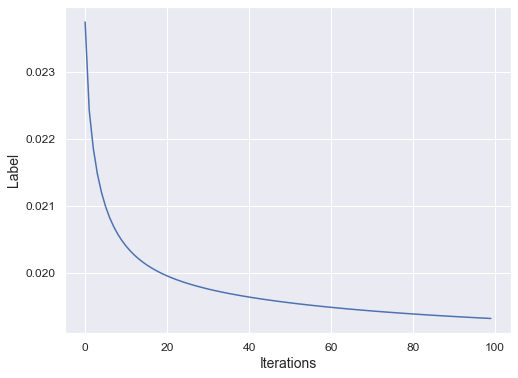

In [65]:
plt.figure()
plt.plot(np.arange(iter), loss)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Label')
plt.show()

Let us calculate the training and testing accuracy of the model.

In [66]:
print('Training accuracy : {0:.4f}'.format(bin_sgd_clf.score(X_train,y_train_0)))
print('Testing accuracy : {0:.4f}'.format(bin_sgd_clf.score(X_test,y_test_0)))

Training accuracy : 0.9943
Testing accuracy : 0.9917


We know that accuracy alone is not a good metric for binary classification.

So let's compute Precision, recall and f1-score for the model.

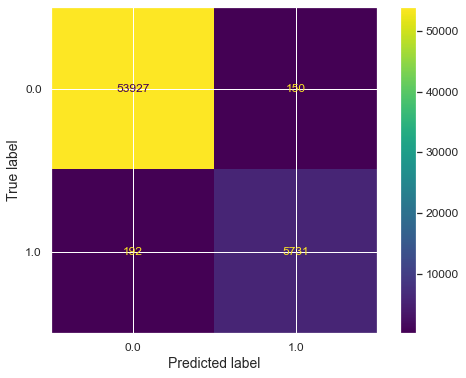

In [67]:
y_hat_train_0 = bin_sgd_clf.predict(X_train)

cm_display = ConfusionMatrixDisplay.from_predictions(
    y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

In [68]:
print(classification_report(y_train_0,y_hat_train_0))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54077
         1.0       0.97      0.97      0.97      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



##### **Cross Validation**

In [69]:
estimator = SGDClassifier(loss='log',
                          penalty='l2',
                          max_iter=100,
                          warm_start=False,
                          eta0=0.01,
                          alpha=0,
                          learning_rate='constant',
                          random_state=1729)

In [70]:
cv_bin_clf = cross_validate(estimator, X_train, y_train_0, cv=5,
                            scoring=['precision', 'recall', 'f1'],
                            return_train_score=True,
                            return_estimator=True)
cv_bin_clf

{'fit_time': array([1.04430604, 1.030128  , 1.03978181, 1.12593508, 0.95098424]),
 'score_time': array([0.0279882 , 0.0270009 , 0.02554798, 0.02606583, 0.02599382]),
 'estimator': [SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
                max_iter=100, random_state=1729),
  SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
                max_iter=100, random_state=1729),
  SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
                max_iter=100, random_state=1729),
  SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
                max_iter=100, random_state=1729),
  SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
                max_iter=100, random_state=1729)],
 'test_precision': array([0.95538721, 0.96382429, 0.97238999, 0.96735395, 0.95952782]),
 'train_precision': array([0.97419355, 0.97321046, 0.96473818, 0.97701149, 0.96404399]),
 'test_recall': array([

* From the above result, we can see that **logistic regression is better than the perceptron**.

* However, it is good to check the weight values of all the features and decide whether regularization could be of any help.


In [71]:
weights = bin_sgd_clf.coef_
bias = bin_sgd_clf.intercept_

print('Bias :', bias)
print('Shape of weights :', weights.shape)
print('Shape of bias :', bias.shape)

Bias : [-5.01034596]
Shape of weights : (1, 784)
Shape of bias : (1,)


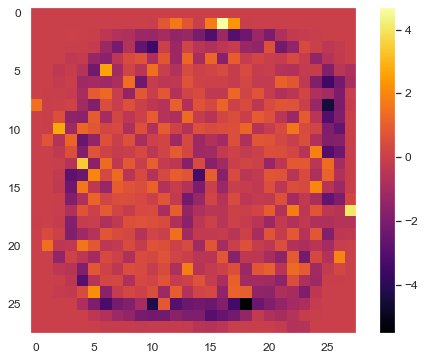

In [72]:
plt.figure()
plt.imshow(weights.reshape(28, 28), cmap='inferno')

plt.grid(False)
plt.colorbar()
plt.show()

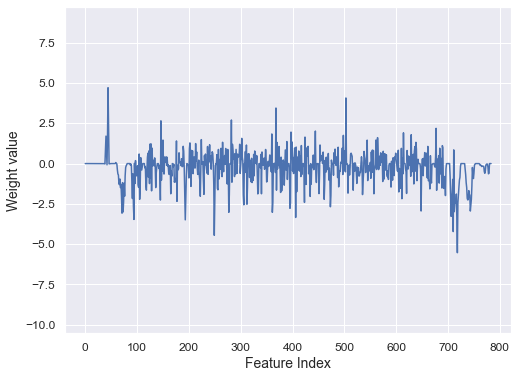

In [73]:
plt.figure() 
plt.plot(np.arange(0,784),weights[0,:])

plt.ylim(np.min(weights[0])-5,np.max(weights[0])+5)
plt.grid(True)

plt.xlabel('Feature Index')
plt.ylabel('Weight value')
plt.show()

* It is interesting to observe that how many weight values are exactly zero.

* Those features contribute nothing in the classification.

In [74]:
zero_weight_idx = np.where(weights[0]==0)
print(len(zero_weight_idx[0]))

# num_zero_w = weights.shape[1]-np.count_nonzero(weights) 
# print("Number of weights with value zero".format(num_zero_w))

67


From the above plot, it is also obvious that regularization is not required.

#### **Training with regularization**

However, what happens to the performance of the model if we penalize, out of temptation, the weight values even to a smaller degree.

In [75]:
bin_sgd_clf_l2 = SGDClassifier(loss='log',
                               penalty='l2',
                               eta0=0.01,
                               alpha=0.001,
                               max_iter=1,
                               warm_start=True,
                               learning_rate='constant',
                               random_state=1729
                               )

In [76]:
loss = [] 
iter =100

for i in range(iter):
  bin_sgd_clf_l2.fit(X_train, y_train_0)
  y_pred = bin_sgd_clf_l2.predict_proba(X_train)
  loss.append(log_loss(y_train_0,y_pred))

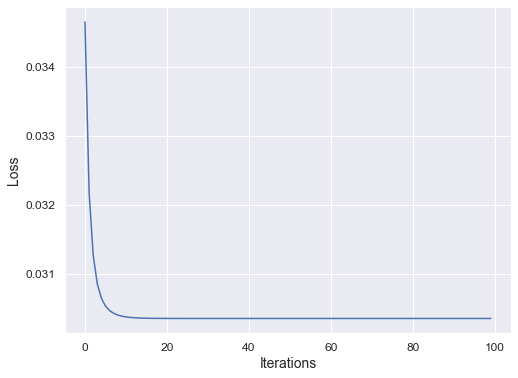

In [77]:
plt.figure()
plt.plot(np.arange(iter), loss)

plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

Let us calculate training and testing accuracy.

In [78]:
print('Training accuracy : {0:.4f}'.format(bin_sgd_clf_l2.score(X_train,y_train_0)))

print('Testing accuracy : {0:.4f}'.format(bin_sgd_clf_l2.score(X_test,y_test_0)))

Training accuracy : 0.9907
Testing accuracy : 0.9905


Let's compute Precision, recall and f1-score for the model.

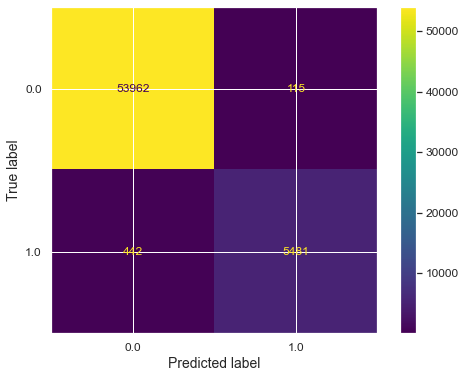

In [79]:
y_hat_train_0 = bin_sgd_clf_l2.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0,values_format='.5g')

In [80]:
print(classification_report(y_train_0,y_hat_train_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



In [81]:
weights = bin_sgd_clf_l2.coef_
bias = bin_sgd_clf_l2.intercept_

print('Bias :', bias)
print('Shape of weights :', weights.shape)
print('Shape of bias :', bias.shape)

Bias : [-4.43002876]
Shape of weights : (1, 784)
Shape of bias : (1,)


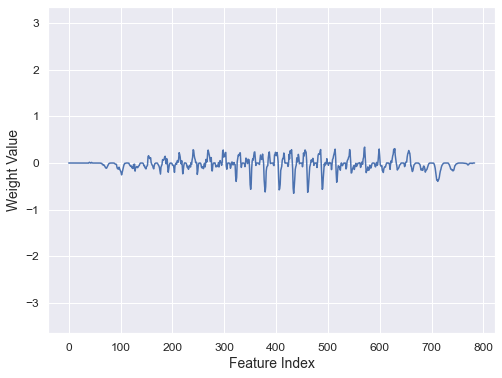

In [82]:
plt.figure()
plt.plot(np.arange(0, 784), weights[0, :])

plt.ylim(np.min(weights[0]-3), np.max(weights[0])+3)
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.grid(True)
plt.show()

Zero weights calculation 

**Note**: Zero weights can't contribute to features.

In [83]:
num_zero_w = len(np.where(weights == 0)[0])
print('Number of zero weight count:', num_zero_w)

Number of zero weight count: 67


#### **Displaying input image and its prediction**

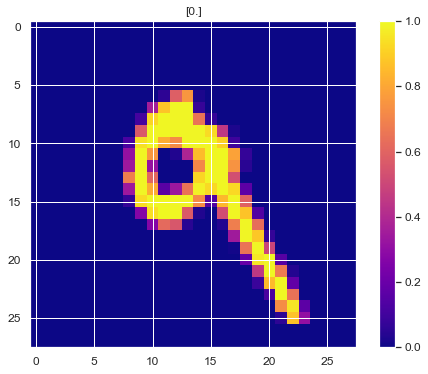

In [84]:
index = 7  # try some other index
plt.imshow(X_test[index, :].reshape(28, 28), cmap='plasma')
plt.colorbar()
pred = bin_sgd_clf_l2.predict(X_test[index].reshape(1, -1))
plt.title(str(pred))
plt.show()


Let's plot a few images and their respective predictions with SGDClassifier without regularization.

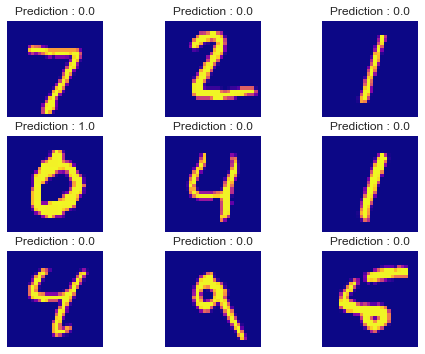

In [85]:
y_hat_test_0 = bin_sgd_clf.predict(X_test) 

num_images = 9  
factor = np.int(np.sqrt(num_images)) 
fig,ax = plt.subplots(nrows=factor, ncols = factor, figsize=(8,6))
idx_offset  = 0 

for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X_test[index+j].reshape(28,28),cmap='plasma')
        
        ax[i,j].set_title('Prediction : {0}'.format(str(y_hat_test_0[index+j])))
        ax[i,j].set_axis_off()

In [86]:
indx_0 = np.where(y_test_0 == 1) 

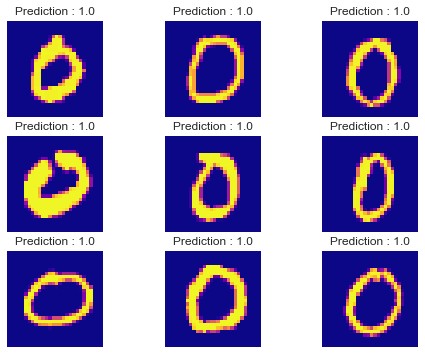

In [87]:
zeroImgs= X_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]

num_images = 9 
factor = np.int(np.sqrt(num_images)) 
fig,ax = plt.subplots(nrows=factor, ncols = factor, figsize=(8,6))
idx_offset  = 0 

for i in range(factor):
    index = idx_offset + i*(factor)
    
    for j in range(factor):
        ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='plasma')
        ax[i,j].set_title('Prediction : {0}'.format(str(zeroLabls[index+j])))
        ax[i,j].set_axis_off()

#### **Hyperparameter Tuning**

* We have to use `cross-validate` folds and mesure the same metrics across these folds for different values of hyper-parameters.

* Logistic regression uses **SGD** solver and hence the two important hyperparameters include : 
    * **learning rate** 

    * **regularization rate** 

* For the moment, we skip penalizing the parameters of the model and just search for a better learning rate using `RandomizedSearchCV()` and draw the value from the uniform distribution.


In [88]:
lr_grid = loguniform(1e-2,1e-1)

* **Note**:  `lr_grid` is an object that contains a method called `rvs()`, which can be used to get the samples of given size.

* Therefore, we pass this `lr_grid` object to `RandomizedSearchCV()`. Internally, it makes use of this `rvs()` method for sampling.

In [89]:
print(lr_grid.rvs(3,random_state=42))

[0.02368864 0.0892718  0.05395031]


In [90]:
estimator = SGDClassifier(loss='log',
                          penalty='l2',
                          max_iter=1,
                          warm_start=True,
                          eta0=0.01,
                          alpha=0,
                          learning_rate='constant',
                          random_state=1729)

scores = RandomizedSearchCV(estimator,
                            param_distributions={'eta0': lr_grid},
                            cv=5,
                            scoring=['precision', 'recall', 'f1'],
                            n_iter=5,
                            refit='f1')


In [91]:
scores.fit(X_train,y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(alpha=0, eta0=0.01,
                                           learning_rate='constant', loss='log',
                                           max_iter=1, random_state=1729,
                                           warm_start=True),
                   n_iter=5,
                   param_distributions={'eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A3C80566D0>},
                   refit='f1', scoring=['precision', 'recall', 'f1'])

In [92]:
scores.cv_results_

{'mean_fit_time': array([0.29237275, 0.29635863, 0.30164819, 0.29441676, 0.30241408]),
 'std_fit_time': array([0.00423318, 0.0040076 , 0.00889626, 0.00300337, 0.0108834 ]),
 'mean_score_time': array([0.02680187, 0.02681022, 0.027     , 0.02519341, 0.02759819]),
 'std_score_time': array([0.00040159, 0.00073386, 0.00109748, 0.00074543, 0.00135997]),
 'param_eta0': masked_array(data=[0.02368863950364078, 0.08927180304353625,
                    0.05395030966670228, 0.039687933304443715,
                    0.01432249371823025],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'eta0': 0.02368863950364078},
  {'eta0': 0.08927180304353625},
  {'eta0': 0.05395030966670228},
  {'eta0': 0.039687933304443715},
  {'eta0': 0.01432249371823025}],
 'split0_test_precision': array([0.93327909, 0.86936937, 0.90101325, 0.91304348, 0.94356846]),
 'split1_test_precision': array([0.95633562, 0.94230769, 0.94839255, 0.95068027, 0.959447

Let us pick the best estimator from the results

In [93]:
best_bin_clf = scores.best_estimator_
best_bin_clf

SGDClassifier(alpha=0, eta0=0.01432249371823025, learning_rate='constant',
              loss='log', max_iter=1, random_state=1729, warm_start=True)

In [94]:
y_hat_train_best_0 = best_bin_clf.predict(X_train)
print(classification_report(y_train_0, y_hat_train_best_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.92      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



#### **Other Evaluation metrics**

##### **1. Precision / Recall Tradeoff**

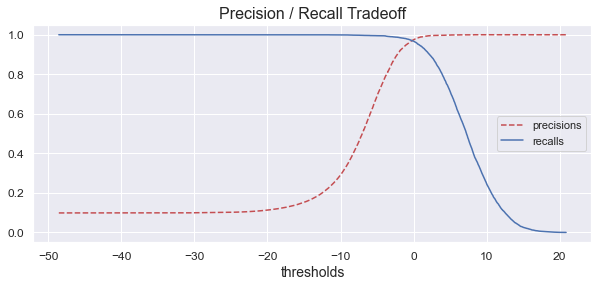

In [95]:
y_scores = bin_sgd_clf.decision_function(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train_0,y_scores)

plt.figure(figsize=(10,4)) 
plt.plot(thresholds,precisions[:-1],'r--',label='precisions')
plt.plot(thresholds,recalls[:-1],'b-',label='recalls')

plt.title('Precision / Recall Tradeoff' ,fontsize=16)
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('thresholds')
plt.show()

##### **2. Precision Recall Curve**

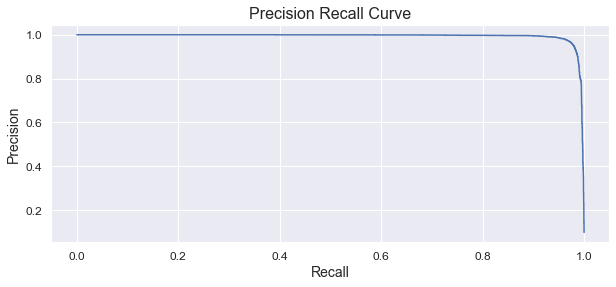

In [96]:
plt.figure(figsize=(10, 4))
plt.plot(recalls[:-1], precisions[:-1], 'b-')

plt.title('Precision Recall Curve', fontsize=16)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

##### **3. ROC curve**

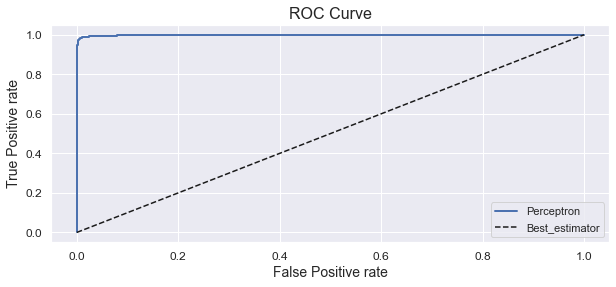

In [97]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)

plt.figure(figsize=(10, 4))
plt.plot(fpr, tpr, linewidth=2, label='Perceptron')
plt.plot([0, 1], [0, 1], 'k--', label='Best_estimator')

plt.title('ROC Curve', fontsize=16)
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.grid(True)
plt.legend()
plt.show()

##### **4. ROC-AUC score**

In [98]:
auc = roc_auc_score(y_train_0, y_scores)
print('AUC : {0:.6f}'.format(auc))

AUC : 0.998627
